# Projet 5 : Segmentez des clients d'un site de e-commerce
Date début : 05/02/2025

# Importation des libraires utiles

In [1]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib import colors
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
%matplotlib inline

import seaborn as sns

import math

from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from scipy.stats import chi2_contingency
import statsmodels.formula.api as smf
import statsmodels.api as sm

import csv

from scipy import stats

import missingno as msno

In [2]:
import sqlite3

# Importation et aperçu des données

In [3]:
data_folder = "D:/GoogleDrive/Mon Drive/formations/OpenClassrooms/P5/"
file_name = "olist.db"

In [4]:
con = sqlite3.connect(data_folder+file_name)

In [5]:
cur = con.cursor()

## Lecture des tables

In [6]:
cur.execute("SELECT * FROM orders")
orders_df = pd.DataFrame(data=cur.fetchall(), columns=np.array(cur.description)[:,0])
orders_df = orders_df.set_index('index')

In [7]:
cur.execute("SELECT * FROM customers")
customers_df = pd.DataFrame(data=cur.fetchall(), columns=np.array(cur.description)[:,0])
customers_df = customers_df.set_index('index')

In [8]:
cur.execute("SELECT * FROM geoloc")
geoloc_df = pd.DataFrame(data=cur.fetchall(), columns=np.array(cur.description)[:,0])
geoloc_df = geoloc_df.set_index('index')

In [9]:
cur.execute("SELECT * FROM order_items")
order_items_df = pd.DataFrame(data=cur.fetchall(), columns=np.array(cur.description)[:,0])
order_items_df = order_items_df.set_index('index')

In [10]:
cur.execute("SELECT * FROM order_pymts")
order_pymts_df = pd.DataFrame(data=cur.fetchall(), columns=np.array(cur.description)[:,0])
order_pymts_df = order_pymts_df.set_index('index')

In [11]:
cur.execute("SELECT * FROM order_reviews")
order_reviews_df = pd.DataFrame(data=cur.fetchall(), columns=np.array(cur.description)[:,0])
order_reviews_df = order_reviews_df.set_index('index')

In [12]:
cur.execute("SELECT * FROM products")
products_df = pd.DataFrame(data=cur.fetchall(), columns=np.array(cur.description)[:,0])
products_df = products_df.set_index('index')

In [13]:
cur.execute("SELECT * FROM sellers")
sellers_df = pd.DataFrame(data=cur.fetchall(), columns=np.array(cur.description)[:,0])
sellers_df = sellers_df.set_index('index')

In [14]:
cur.execute("SELECT * FROM translation")
translation_df = pd.DataFrame(data=cur.fetchall(), columns=np.array(cur.description)[:,0])
translation_df = translation_df.set_index('index')

## Aperçu des données

In [15]:
customers_df

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
index,,,,,
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP
...,...,...,...,...,...
99436,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP
99437,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP
99438,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE


In [16]:
order_items_df

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
index,,,,,,,
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14
...,...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95


In [17]:
products_df

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
index,,,,,,,,,
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0
...,...,...,...,...,...,...,...,...,...
32946,a0b7d5a992ccda646f2d34e418fff5a0,moveis_decoracao,45.0,67.0,2.0,12300.0,40.0,40.0,40.0
32947,bf4538d88321d0fd4412a93c974510e6,construcao_ferramentas_iluminacao,41.0,971.0,1.0,1700.0,16.0,19.0,16.0
32948,9a7c6041fa9592d9d9ef6cfe62a71f8c,cama_mesa_banho,50.0,799.0,1.0,1400.0,27.0,7.0,27.0


In [18]:
orders_df

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
index,,,,,,,,
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00
...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28 00:00:00
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00


In [19]:
order_pymts_df

,order_id,payment_sequential,payment_type,payment_installments,payment_value
index,,,,,
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45
...,...,...,...,...,...
103881,0406037ad97740d563a178ecc7a2075c,1,boleto,1,363.31
103882,7b905861d7c825891d6347454ea7863f,1,credit_card,2,96.80
103883,32609bbb3dd69b3c066a6860554a77bf,1,credit_card,1,47.77


In [20]:
order_reviews_df

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
index,,,,,,,
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,None,None,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,None,None,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,None,None,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,None,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,None,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53
...,...,...,...,...,...,...,...
99219,574ed12dd733e5fa530cfd4bbf39d7c9,2a8c23fee101d4d5662fa670396eb8da,5,None,None,2018-07-07 00:00:00,2018-07-14 17:18:30
99220,f3897127253a9592a73be9bdfdf4ed7a,22ec9f0669f784db00fa86d035cf8602,5,None,None,2017-12-09 00:00:00,2017-12-11 20:06:42
99221,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,5,None,"Excelente mochila, entrega super rápida. Super...",2018-03-22 00:00:00,2018-03-23 09:10:43


In [21]:
sellers_df

,seller_id,seller_zip_code_prefix,seller_city,seller_state
index,,,,
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP
...,...,...,...,...
3090,98dddbc4601dd4443ca174359b237166,87111,sarandi,PR
3091,f8201cab383e484733266d1906e2fdfa,88137,palhoca,SC
3092,74871d19219c7d518d0090283e03c137,4650,sao paulo,SP


In [22]:
geoloc_df

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
index,,,,,
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP
...,...,...,...,...,...
1000158,99950,-28.068639,-52.010705,tapejara,RS
1000159,99900,-27.877125,-52.224882,getulio vargas,RS
1000160,99950,-28.071855,-52.014716,tapejara,RS


In [23]:
translation_df

,product_category_name,product_category_name_english
index,,
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor
...,...,...
66,flores,flowers
67,artes_e_artesanato,arts_and_craftmanship
68,fraldas_higiene,diapers_and_hygiene


# RFM

## Création de la table de données gloable RFM

In [24]:
data_RFM = customers_df.merge(orders_df, 'outer', on = 'customer_id')

In [25]:
data_RFM = data_RFM.merge(order_items_df, 'outer', on = 'order_id')

In [26]:
data_RFM['order_purchase_timestamp'] = pd.to_datetime(data_RFM['order_purchase_timestamp'])

In [27]:
data_RFM = data_RFM.loc[~data_RFM['price'].isnull()]

In [29]:
data_RFM_grouped = data_RFM.groupby(by=['customer_id'])

In [30]:
data_RFM_stats = pd.DataFrame()
data_RFM_stats['Monetary'] = data_RFM_grouped['price'].sum()
data_RFM_stats['LastDate'] = data_RFM_grouped['order_purchase_timestamp'].max()
data_RFM_stats['Frequency'] = data_RFM_grouped['order_id'].size()

In [31]:
data_RFM_stats['Recency'] = (data_RFM_stats['LastDate'].max() - data_RFM_stats['LastDate']).dt.days

## Classification des données

In [32]:
R_bins = [0, 90, 180, 365, 650, data_RFM_stats['Recency'].max()]
F_bins = [0, 1, data_RFM_stats['Frequency'].max()]
M_bins = [0, 50, 150, 300, 1000, data_RFM_stats['Monetary'].max()]

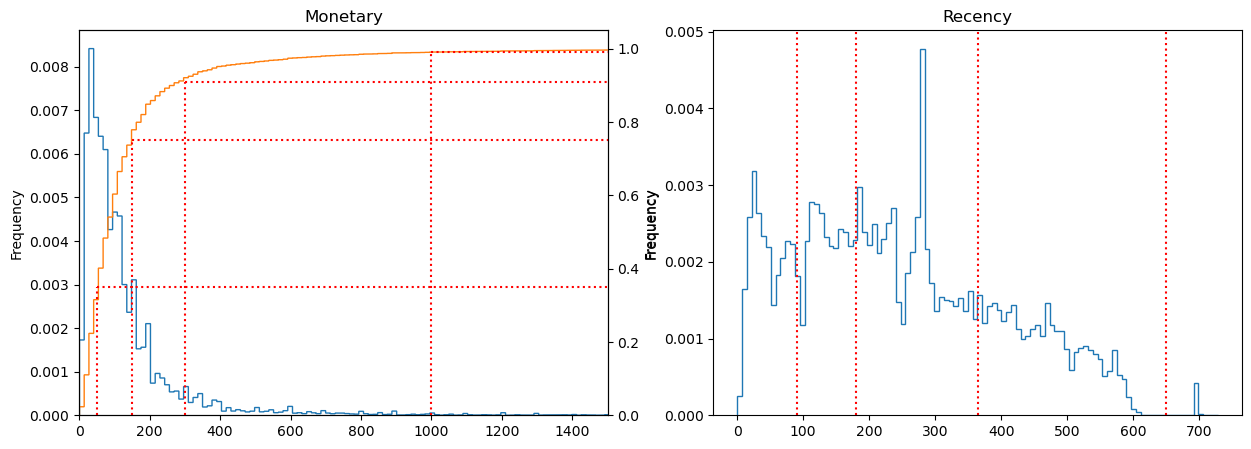

In [56]:
x_max = 1500
f_cum = [0.35, 0.75, 0.91, 0.99]

plt.figure(figsize=(15,5))

ax = plt.subplot(1,2,1)
data_RFM_stats['Monetary'].plot.hist(ax=ax, bins=1000, density = True, histtype='step')
ax = ax.twinx()
data_RFM_stats['Monetary'].plot.hist(ax=ax, bins=1000, density=True, cumulative=True, histtype='step', color='tab:orange')

for i in range(4):
    ax.plot([M_bins[i+1], x_max], [f_cum[i], f_cum[i]], ':r')
    ax.plot([M_bins[i+1], M_bins[i+1]], [0, f_cum[i]], ':r')

ax.set_title('Monetary')
plt.xlim([0,x_max])

ax = plt.subplot(1,2,2)
data_RFM_stats['Recency'].plot.hist(ax=ax, bins=100, density = True, histtype='step')

for i in range(4):
    ax.axvline(R_bins[i+1], linestyle=':', color='r')

ax.set_title('Recency')
plt.show()

In [35]:
data_RFM_stats['R'] = pd.cut(data_RFM_stats['Recency'], bins=R_bins, labels = range(1, 6), include_lowest=True).astype(str)
data_RFM_stats['M'] = pd.cut(data_RFM_stats['Monetary'], bins=M_bins, labels = range(1, 6), include_lowest=True).astype(str)
data_RFM_stats['F'] = pd.cut(data_RFM_stats['Frequency'], bins=F_bins, labels = range(1, 3), include_lowest=True).astype(str)

In [36]:
data_RFM_stats['RFM'] = data_RFM_stats['R'] + data_RFM_stats['F'] + data_RFM_stats['M']

In [37]:
data_RFM_stats_grouped = data_RFM_stats.groupby(by='RFM')

In [38]:
data_RFM_stats_density = pd.DataFrame()
data_RFM_stats_density['R'] = data_RFM_stats_grouped['R'].first()
data_RFM_stats_density['F'] = data_RFM_stats_grouped['F'].first()
data_RFM_stats_density['M'] = data_RFM_stats_grouped['M'].first()
data_RFM_stats_density['d'] = data_RFM_stats_grouped['R'].size()

## Représentation RFM

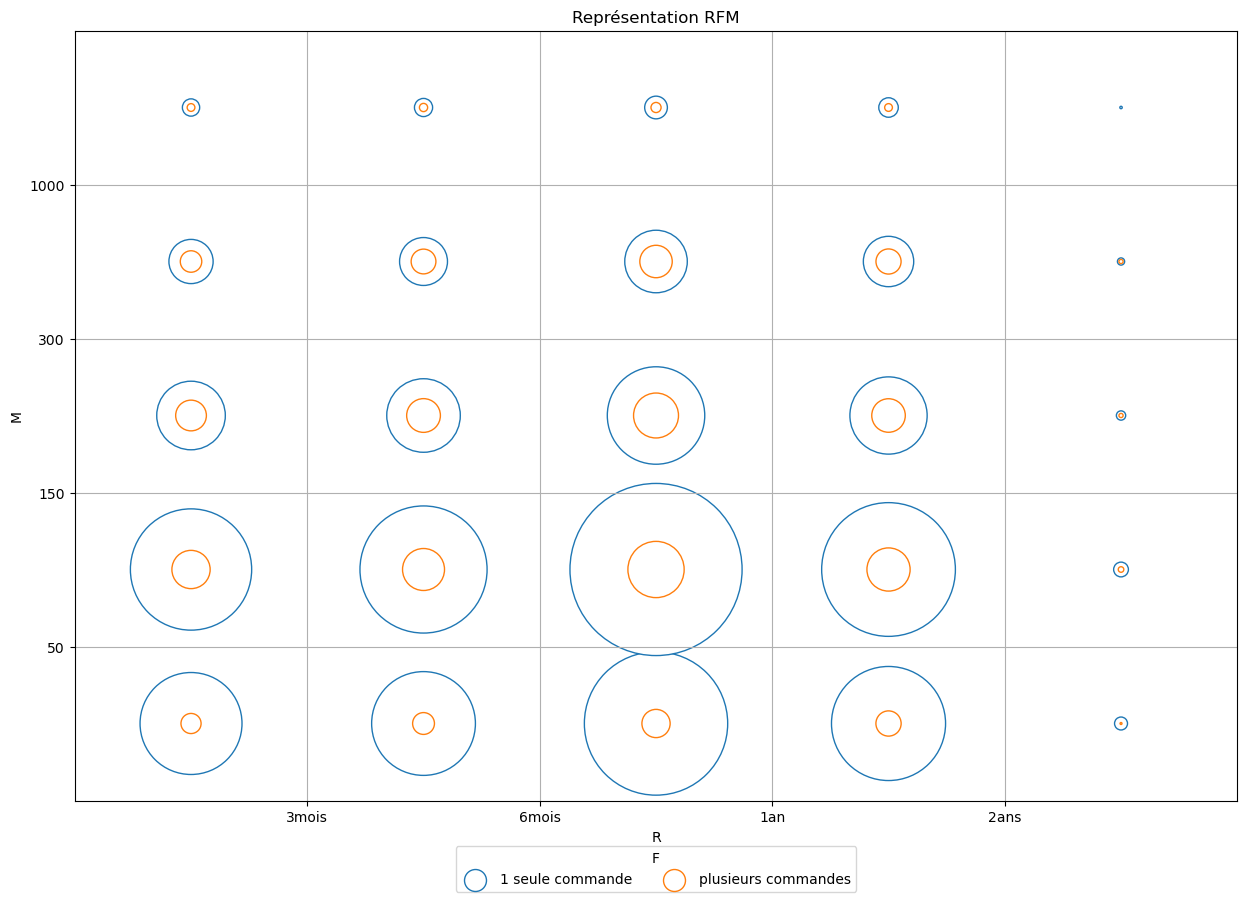

In [39]:
plt.figure(figsize=(15,10))

ax = plt.subplot(1,1,1)
data_RFM_stats_density.loc[data_RFM_stats_density['F']=='1'].plot.scatter(ax=ax, x='R', y='M', s='d', label='1 seule commande',
                                                                          marker='o', edgecolors='tab:blue', color='w')
data_RFM_stats_density.loc[data_RFM_stats_density['F']=='2'].plot.scatter(ax=ax, x='R', y='M', s='d', label='plusieurs commandes',
                                                                          marker='o', edgecolors='tab:orange', color='w')

ax.set_xticks([0.5, 1.5, 2.5, 3.5], ['3mois', '6mois', '1an', '2ans'])
ax.set_yticks([0.5, 1.5, 2.5, 3.5], M_bins[1:-1])
plt.xlim([-0.5, 4.5])
plt.ylim([-0.5, 4.5])
plt.grid()
lgnd = plt.legend(title='F', loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)
lgnd.legend_handles[1].set_sizes([250])
lgnd.legend_handles[0].set_sizes([250])

plt.title('Représentation RFM')

plt.show()